# Extraction and plotting of gene expression data using a surface atlas

First do all the non-optional imports

In [21]:
import abagen
import numpy as np
import nibabel as nib
from nilearn import plotting
from matplotlib import pyplot as plt

/home/dings/miniconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Get the atlas information

In [4]:
# this will download the atlas files if not already present
atlas_deskil = abagen.fetch_desikan_killiany(surface=True)

In [5]:
# Optionally: check the atlas
from abagen import images
images.check_atlas(atlas_deskil['image'], space='fsaverage')

AtlasTree[n_rois=68, n_vertex=18426]

In [10]:
# optional: print the contents nicely
# it contains separate label giftis for each of the two hemispheres
# the data contained in the gifti is described later

import json
print("# Atlas data files: ")
print(json.dumps(atlas_deskil, indent=2))

# Atlas data files: 
{
  "image": [
    "/home/dings/miniconda3/lib/python3.8/site-packages/abagen/data/atlas-desikankilliany-lh.label.gii.gz",
    "/home/dings/miniconda3/lib/python3.8/site-packages/abagen/data/atlas-desikankilliany-rh.label.gii.gz"
  ],
  "info": "/home/dings/miniconda3/lib/python3.8/site-packages/abagen/data/atlas-desikankilliany.csv"
}


In [11]:
# optional: also look  at the contents of the additional information contained in the csv-file
# this basically contains a mapping between labels (=integer numbers) and actual label names, hemisphere, and region
# also decribed in here 
# https://abagen.readthedocs.io/en/stable/user_guide/parcellations.html#providing-additional-parcellation-info
import pandas as pd
print("\n# Additional atlas info fromt the csv: ")
atlas_deskil_info = pd.read_csv(atlas_deskil['info'])
atlas_deskil_info


# Additional atlas info fromt the csv: 


,id,label,hemisphere,structure
0,1,bankssts,L,cortex
1,2,caudalanteriorcingulate,L,cortex
2,3,caudalmiddlefrontal,L,cortex
3,4,cuneus,L,cortex
4,5,entorhinal,L,cortex
...,...,...,...,...
78,79,pallidum,R,subcortex/brainstem
79,80,accumbensarea,R,subcortex/brainstem
80,81,hippocampus,R,subcortex/brainstem
81,82,amygdala,R,subcortex/brainstem


## Plot surface atlas data

In order to use the atlas data for plotting, the underlying gifti file containing the mapping between greyordinate index and region label needs to be loaded. 
I use nibabel for that, which requires the atlas to be unzipped, so we do that first:

In [12]:
import subprocess

# this can be also done from the command line or the OS file explorer directly
# it exctracts the file to the same location and also (-k) keeps the original archive
subprocess.call(["gunzip", "-k", atlas_deskil['image'][0]])

2

In [19]:
# now actually load the atlas data
filename=atlas_deskil['image'][0].rstrip(".gz");
kil = nib.load(filename)

# each gifti file can contain mutliple arrays with data
# for a contiguous brain structure (here we only use the left hemisphere)
# here we have just one array, containing data of shape
# [num_greyordinate vertices,]
desikan_killiany_parcel_data_L =kil.darrays[0].data

# print the data and shape
print("File: ", filename, "\n")
print("Contains data: ", desikan_killiany_parcel_data_L, " of shape: ", desikan_killiany_parcel_data_L.shape)


File:  /home/dings/miniconda3/lib/python3.8/site-packages/abagen/data/atlas-desikankilliany-lh.label.gii 

Contains data:  [23 28 27 ... 15 15 15]  of shape:  (10242,)


Now plot the atlas itself. For that we need also the inflates fsaverage5 (the space in which the atlas is contained) "surf" gifti containing the 3D information about the position/size of greyordinate vertices.

This can be downloaded using the nilearn library. Alternatively you can also provide your own path to it in the next cell:

In [60]:
# optional: download the surface gifti files for fsaverage5
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5', \
     data_dir= r"/mnt/c/tmp/OwnCloud/data/CortexParcellations/freesurfer/")
print(fsaverage.infl_left)


/home/dings/miniconda3/lib/python3.8/site-packages/nilearn/datasets/data/fsaverage5/pial_inflated.left.gii.gz


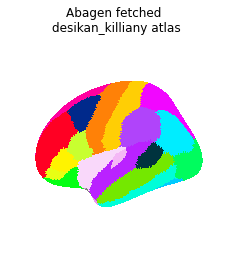

In [59]:
# file should look like: fsaverage5/pial_inflated.left.gii.gz
surf_gifti_file_L = fsaverage.infl_left

fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.set_title("Abagen fetched \ndesikan_killiany atlas");

# plot_surf_roi was specifically created for plotting atlas roi data
plotting.plot_surf_roi(surf_gifti_file_L, roi_map=desikan_killiany_parcel_data_L, hemi='left', \
                       view='lateral', axes=ax);

## Gene Expression Data

Get some expression data for this parcellation. Here I just use two donors. If their data was not fetched before, it will be downloaded automatically to your file system. Either process will take a short while.

In [43]:
expression = abagen.get_expression_data(atlas_deskil['image'], atlas_deskil['info'], donors=['12876', '15496'])
# rows of the data correspond to the atlas parcels (integer values corresponding to the labels)
# columns contain data for a secific gene (given by gene_symbol)
print("Fetched data for the parcellation of shape: ", expression.shape)

Fetched data for the parcellation of shape:  (68, 15666)


In [71]:
print("Expression for SST in parcel 3: ", expression.loc[3, "SST"], "\n")

# Shows the returned data
# some columns are NAN because either no vertices with that parcel values  
# were in the atlas_deskil['image'] gii, or no sample was taken from (nearby) that area
# the behaviour of sample selection can be changed:
# https://abagen.readthedocs.io/en/stable/user_guide/expression.html
expression

Expression for SST in parcel 3:  0.3326749451405768 



gene_symbol,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
label,,,,,,,,,,,,,,,,,,,,,
1,0.593756,0.743633,0.438943,0.433752,0.449750,0.107494,0.649463,0.752119,0.435063,0.603111,...,0.609396,0.376677,0.495330,0.517574,0.536820,0.665906,0.557561,0.544552,0.683457,0.553690
2,0.705605,0.319990,0.306970,0.786118,0.497700,0.571663,0.287605,0.199311,0.642875,0.651802,...,0.236904,0.244770,0.247410,0.335402,0.212586,0.669352,0.336111,0.131641,0.349210,0.428440
3,0.515246,0.483147,0.666010,0.476721,0.547662,0.576097,0.496866,0.482961,0.411025,0.290573,...,0.337274,0.482110,0.475619,0.496805,0.452993,0.541437,0.378600,0.536585,0.515516,0.491299
4,0.481121,0.403623,0.320960,0.324920,0.295794,0.434921,0.612803,0.369355,0.501640,0.409573,...,0.627550,0.543743,0.423570,0.543206,0.404959,0.374872,0.350431,0.913360,0.692557,0.324770
5,0.704936,0.080817,0.638987,0.544349,0.441415,0.379062,0.419166,0.189376,0.647793,0.523043,...,0.569488,0.217785,0.770491,0.435032,0.396713,0.639960,0.484919,0.055026,0.534682,0.453444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Optional: find your preffered gene(s) using the probe info of a sample donor

files = abagen.fetch_microarray(donors=['12876', '15496'], data_dir='res/abagen_human')  
data = files['15496']
# annotations contain MNI locations for samples
# i assume all probes were quantified on a per sample basis
# annotation = abagen.io.read_annotation(data['annotation'])

# probes contain more information about the actual genetics that 
# have been quantified
probes = abagen.io.read_probes(data['probes']);

#here are some commands that could be used
# for finding markers of different interneurons
# SST corresponds to SOM interneurons
print("Gene symbols for SST: ", [x for x in probes['gene_symbol'] if "SST" in x]) 
print("\n#More detail:")
print(probes[probes['gene_name']=="somatostatin"])
#probes[probes['gene_symbol']=="VIP"]

Gene symbols for SST:  ['SSTR1', 'SSTR1', 'SSTR2', 'SSTR2', 'SSTR3', 'SSTR3', 'SSTR4', 'SSTR4', 'SSTR5', 'SSTR5', 'SST', 'SST', 'SST', 'SST', 'SSTR5-AS1', 'SSTR5-AS1']

#More detail:
                      probe_name  gene_id gene_symbol     gene_name  \
probe_id                                                              
1025754   CUST_14458_PI416261804     6710         SST  somatostatin   
1025749             A_23_P252817     6710         SST  somatostatin   
1025748     CUST_979_PI417557136     6710         SST  somatostatin   
1025747     CUST_980_PI417557136     6710         SST  somatostatin   

          entrez_id chromosome  
probe_id                        
1025754        6750          3  
1025749        6750          3  
1025748        6750          3  
1025747        6750          3  


## Plotting parcellated gene expression data on fsaverage5 surface

For that we use the standard plotting function of the nilearn package and plot the vertex wise values for the gene expression levels (all vertices belonging to one ROI/parcel receive the same values)

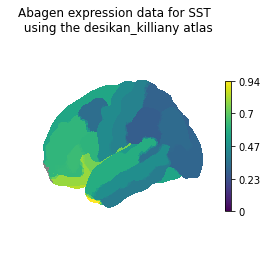

In [69]:
# the gene_symbol of interest
genesym = "SST"

# create an empty dummy array for all vertices in the left hemisphere
gene_surf_data = np.zeros(desikan_killiany_parcel_data_L.shape)

# go over all the labels (indicating the parcels, i.e. V1) from the atlas (only in the left hemisphere)
# and assign the gene expression value extracted for that parcel
# to all the voxels belonging to that parcel
# (except for 0 which indicates that a greyvoxel vertex is not assigned)
for uval in np.unique(desikan_killiany_parcel_data_L):
  if uval==0: continue;
  expv = expression.loc[uval, genesym];
  gene_surf_data[desikan_killiany_parcel_data_L==uval] = expv;
    
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.set_title("Abagen expression data for SST \n using the desikan_killiany atlas");
plotting.plot_surf(fsaverage['pial_left'], surf_map=gene_surf_data, hemi='left', \
                   axes = ax, view='lateral', colorbar=True);

## TBD: Check the probe coverage of the parcellation visually

One last thing that can be done is checking where the genetics data actually came from, especially if ROIs tend to be somewhat big. This can be done in a very coarse manner visually:

In [73]:
# get donor sample info again:

files = abagen.fetch_microarray(donors=['12876', '15496'], data_dir='res/abagen_human')  
data = files['15496']

# annotations contain MNI locations for samples
# i assume all probes were quantified on a per sample basis

annotation = abagen.io.read_annotation(data['annotation']);

In [75]:
annotation

,structure_id,slab_num,well_id,slab_type,structure_acronym,structure_name,polygon_id,mri_voxel_x,mri_voxel_y,mri_voxel_z,mni_x,mni_y,mni_z
sample_id,,,,,,,,,,,,,
1,4215,13,141667089,CX,SOG-i,"superior occipital gyrus, left, inferior bank ...",127562730,141,88,171,-50.0,-80.0,21.0
2,4237,11,141667177,CX,CgGr-s,"cingulate gyrus, retrosplenial part, left, sup...",127512019,109,111,144,-18.0,-53.0,-2.0
3,4090,9,141667207,CX,PoG-pcs,"postcentral gyrus, left, bank of the posterior...",127050458,138,59,118,-47.0,-27.0,50.0
4,4107,9,139409861,CX,SMG-i,"supramarginal gyrus, left, inferior bank of gyrus",127050410,159,79,119,-68.0,-28.0,30.0
5,4106,9,139409845,CX,SMG-s,"supramarginal gyrus, left, superior bank of gyrus",127050409,149,64,119,-58.0,-28.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,9067,8,156907008,CX,VTA,"ventral tegmental area, left",126972550,103,121,105,-12.0,-14.0,-12.0
467,9075,8,156906992,CX,SNR,"substantia nigra, pars reticulata, left",126971019,108,123,106,-17.0,-15.0,-14.0
468,4322,8,147628255,CX,Cl,"claustrum, left",121079176,132,117,107,-41.0,-16.0,-8.0


Now the samples in MNI coordinates have to be assigned to the parcels ...